In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json

## Baseline model

In [68]:
current_dir = os.getcwd()
results = pd.read_csv(current_dir + '/results/results_mosei_MISA_dropout(0.6)_batchsize(32)_epoch(40).csv')

In [70]:
results_json = current_dir + '/results/results_MISA_baseline_dropout(0.6)-batchsize(32)_epoch(40).json'
with open(results_json) as f:
    results_dict = json.load(f)

results_dict

{'loss': 2.915573379764818,
 'accuracy': 0.447,
 'precision': 0.43386606530051963,
 'recall': 0.6993835941204363,
 'f1': 0.5355197870022994,
 'acc_va': 0.2828,
 'acc_ta': 0.4467,
 'acc_tv': 0.4142,
 'acc_t': 0.4063,
 'acc_v': 0.283,
 'acc_a': 0.2823}

In [71]:
'''confidNet results
labels: ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
'''
results.head()

,id,input_sentence,label,prediction,predicted_scores,tcp_TVA,tcp_AV,tcp_TA,tcp_TV,tcp_T,tcp_V,tcp_A
0,-6rXp3zJ3kc[1],very aware of many people are not until they g...,[0. 1. 0. 0. 0. 0.],[1. 1. 0. 0. 0. 1.],[0.50314033 0.45130315 0.32472774 0.34642982 0...,0.451303,0.488268,0.413401,0.354625,0.284283,0.370325,0.403522
1,-AUZQgSxyPQ[0],the perfect soul mate to the spot therapy brus...,[0. 0. 0. 0. 0. 1.],[1. 0. 0. 0. 0. 0.],[0.6451202 0.28732434 0.2038668 0.26522315 0...,0.290457,0.213929,0.294480,0.296826,0.254338,0.200501,0.196946
2,-6rXp3zJ3kc[2],so the answer to the question can i contribute...,[0. 1. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0.],[0.5910013 0.29055703 0.263067 0.23342206 0...,0.290557,0.480802,0.283392,0.223852,0.189869,0.351033,0.406520
3,-MeTTeMJBNc[3],picture maybe you could find a picture of the ...,[1. 0. 0. 1. 0. 0.],[1. 0. 0. 0. 0. 0.],[0.5306394 0.34987083 0.25639173 0.28216556 0...,0.406402,0.361421,0.416134,0.461694,0.459285,0.400974,0.354839
4,-RfYyzHpjk4[3],time you can use it for personal use family fr...,[1. 0. 1. 0. 1. 0.],[1. 0. 0. 0. 0. 0.],[0.6350371 0.24289446 0.21855064 0.18760787 0...,0.326033,0.499758,0.310471,0.319213,0.294443,0.456819,0.471502


In [72]:
print(len(results))

4654


In [73]:
results['label'].loc[lambda x: x =='[0. 0. 0. 0. 0. 0.]'].count()

701

In [74]:
# Drop the rows with no label
results = results[results['label'] != '[0. 0. 0. 0. 0. 0.]']
print(results.shape[0])

3953


In [95]:
text_is_noise = results[results['tcp_AV'] > results['tcp_TVA']]
audio_is_noise = results[results['tcp_TV'] > results['tcp_TVA']]
video_is_noise = results[results['tcp_TA'] > results['tcp_TVA']]

In [96]:
# Modality noise counts with no label rows dropped
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  3953
Textual noise counts:  1984
Visual noise counts:  554
Audio noise counts:  2214


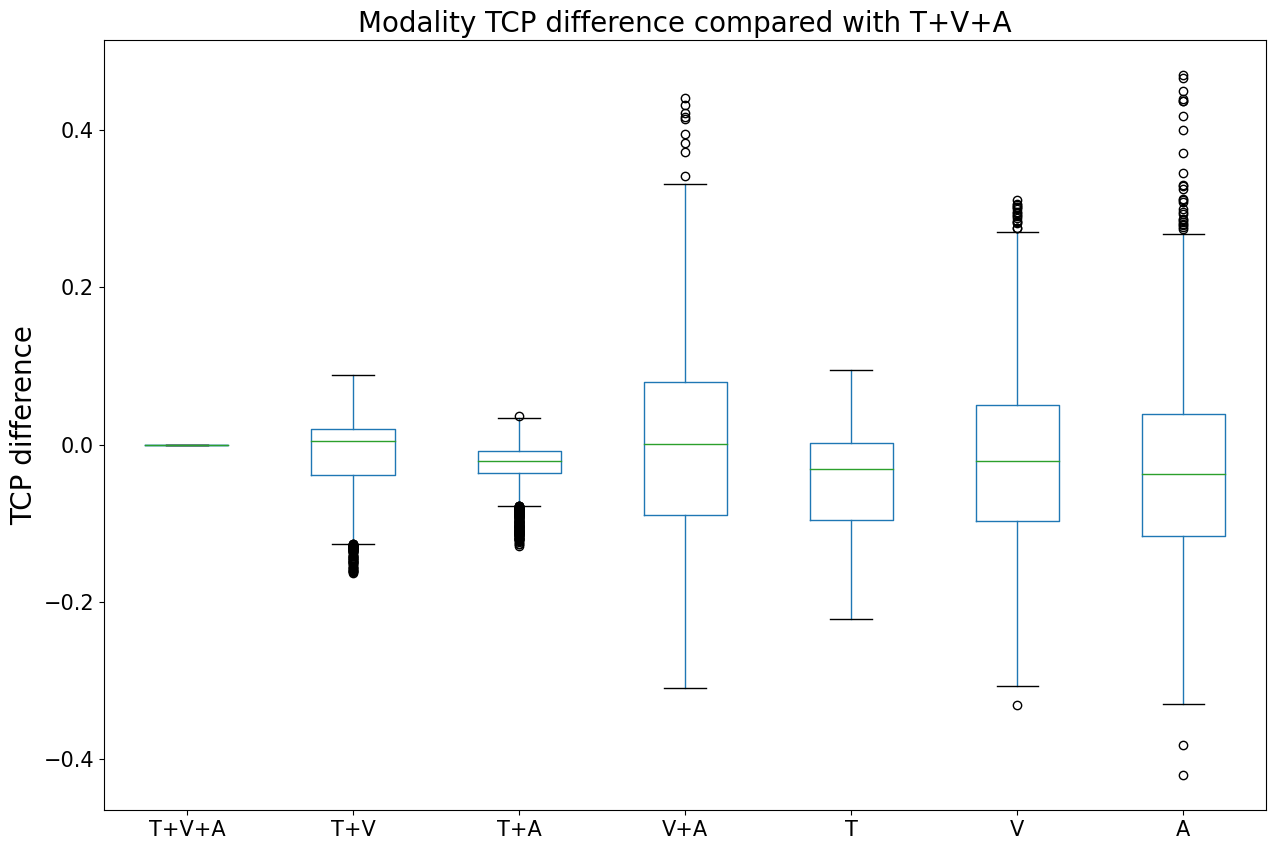

In [97]:
df_diff = pd.DataFrame()
df_diff['T+V+A'] = results['tcp_TVA'] - results['tcp_TVA']
df_diff['T+V'] = results['tcp_TV'] - results['tcp_TVA']
df_diff['T+A'] = results['tcp_TA'] - results['tcp_TVA']
df_diff['V+A'] = results['tcp_AV'] - results['tcp_TVA']
df_diff['T'] = results['tcp_T'] - results['tcp_TVA']
df_diff['V'] = results['tcp_V'] - results['tcp_TVA']
df_diff['A'] = results['tcp_A'] - results['tcp_TVA']

box = df_diff.boxplot(column=['T+V+A', 'T+V', 'T+A', 'V+A', 'T', 'V', 'A'], figsize=(15, 10), grid=False, fontsize=15)
box.set_title('Modality TCP difference compared with T+V+A', fontsize=20)
box.set_ylabel('TCP difference', fontsize=20)
plt.show()

In [98]:
plt.close()

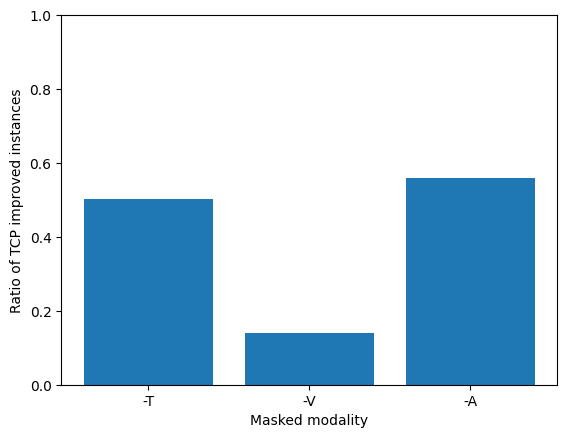

In [99]:
# Ratio of TCP improved instances for each modality masking
columns = ['-T', '-V', '-A']

tcp_improved_ratio = [
    (results['tcp_AV'] > results['tcp_TVA']).sum() / results.shape[0],
    (results['tcp_TA'] > results['tcp_TVA']).sum() / results.shape[0],
    (results['tcp_TV'] > results['tcp_TVA']).sum() / results.shape[0]
]

plt.bar(columns, tcp_improved_ratio)
plt.ylim(0, 1)
plt.xlabel("Masked modality")
plt.ylabel("Ratio of TCP improved instances")
plt.show()

In [100]:
plt.close()

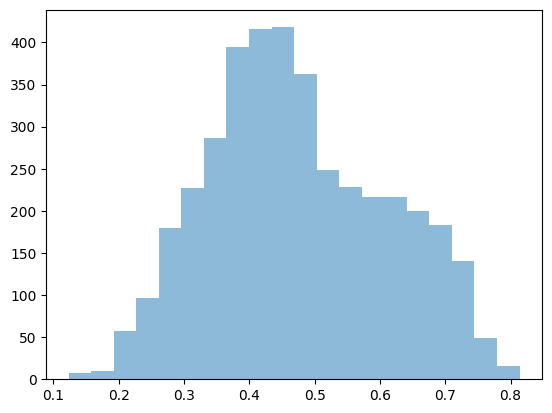

In [101]:
ax = results['tcp_TVA'].hist(bins=20, alpha=0.5, grid=False)
plt.show()

In [102]:
plt.close()

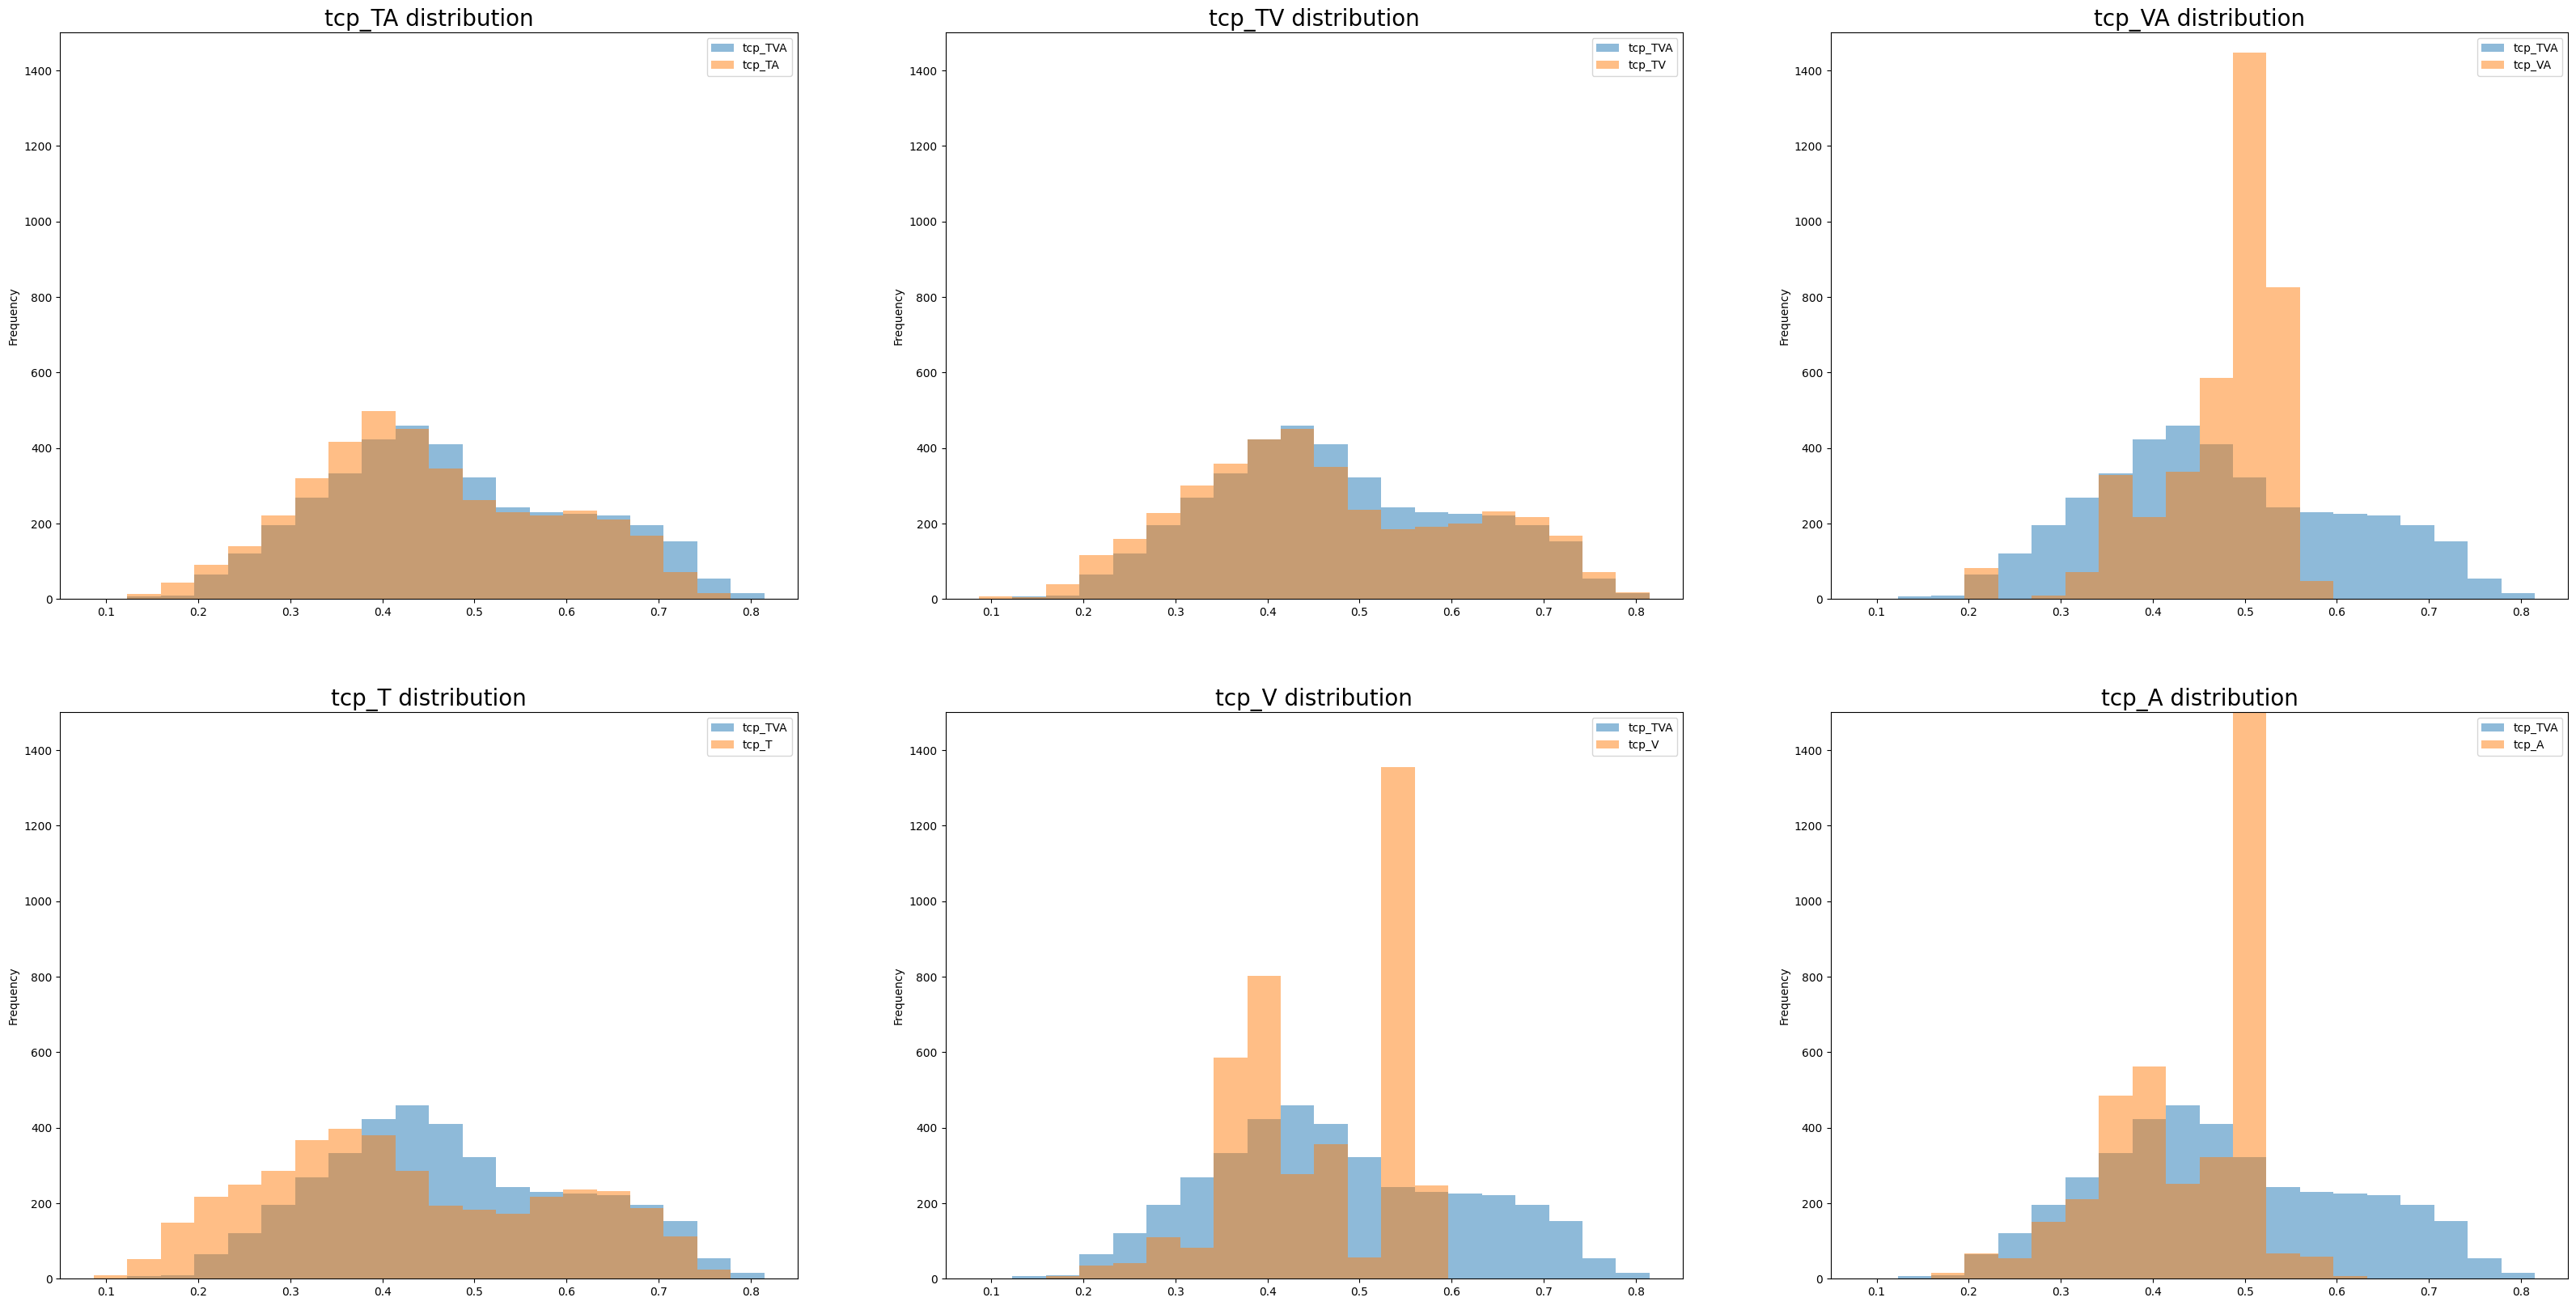

In [83]:
df = pd.DataFrame({
    'tcp_TVA': results['tcp_TVA'],
    'tcp_TA': results['tcp_TA'],
    'tcp_TV': results['tcp_TV'],
    'tcp_VA': results['tcp_AV'],
    'tcp_T': results['tcp_T'],
    'tcp_V': results['tcp_V'],
    'tcp_A': results['tcp_A']
})
fig, ax = plt.subplots(2, 3, figsize=(40, 20))
m=0
for i in range(2):
    for j in range(3):
        df.plot.hist(column='tcp_TVA', bins=20, ax=ax[i,j], alpha=0.5, ylim=(0, 1500))
        df.plot.hist(column=df.columns[m+1], bins=20, ax=ax[i,j], alpha=0.5, ylim=(0, 1500))
        ax[i,j].set_title('{} distribution'.format(df.columns[m+1]), fontsize=20)
        m+=1
        if m == 7:
            break
plt.show()

In [84]:
plt.close()

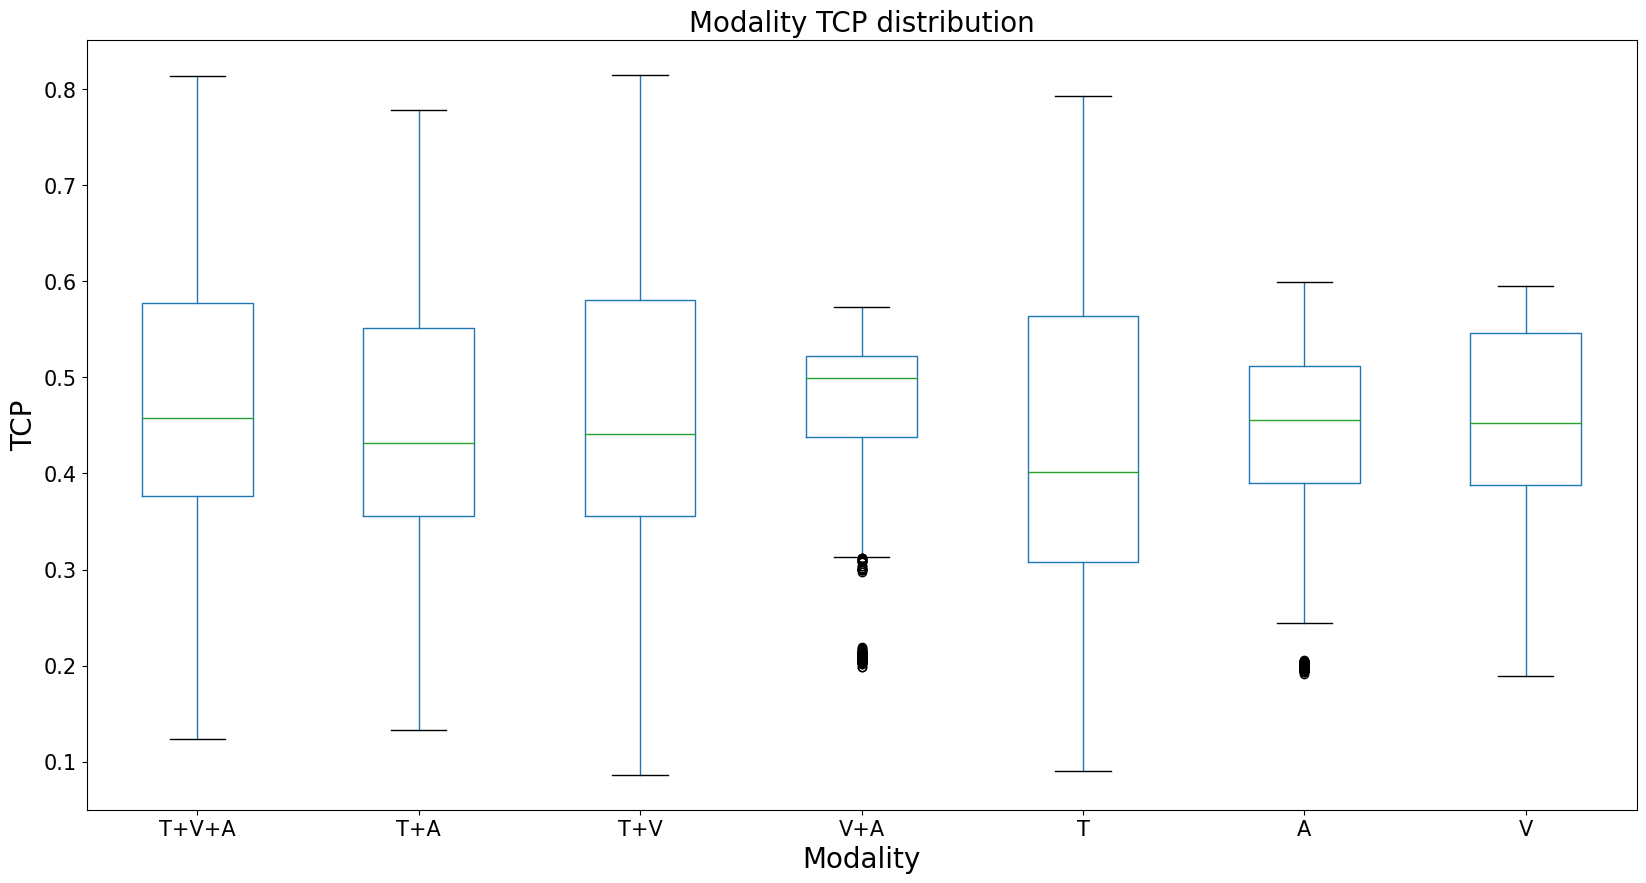

In [85]:
df = pd.DataFrame({'T+V+A': results['tcp_TVA'], 'T+A': results['tcp_TA'], 'T+V': results['tcp_TV'], 'V+A': results['tcp_AV'], 'T': results['tcp_T'], 'V': results['tcp_V'], 'A': results['tcp_A']})  
box_plot = df.boxplot(column=['T+V+A', 'T+A', 'T+V', 'V+A', 'T', 'A', 'V'], figsize=(20, 10), grid=False, fontsize=15)
box_plot.set_title('Modality TCP distribution', fontsize=20)
box_plot.set_ylabel('TCP', fontsize=20)
box_plot.set_xlabel('Modality', fontsize=20)
plt.show()

In [86]:
plt.close()

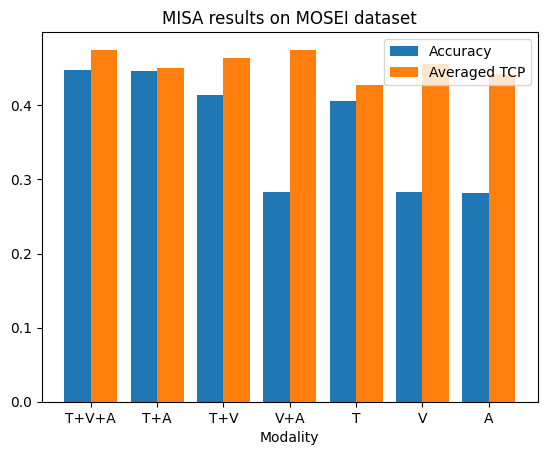

In [87]:
columns = ['T+V+A', 'T+A', 'T+V', 'V+A', 'T', 'V', 'A']
X_axis = np.arange(len(columns))

accuracy = [
    results_dict['accuracy'], results_dict['acc_ta'], results_dict['acc_tv'], results_dict['acc_va'], results_dict['acc_t'], results_dict['acc_v'], results_dict['acc_a']
]

average_tcp = [
    np.mean(results['tcp_TVA']), 
    np.mean(results['tcp_TA']), 
    np.mean(results['tcp_TV']), 
    np.mean(results['tcp_AV']), 
    np.mean(results['tcp_T']),
    np.mean(results['tcp_V']), 
    np.mean(results['tcp_A'])
]

# histogram of the data
plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, average_tcp, 0.4, label = 'Averaged TCP')

plt.xticks(X_axis, columns)
plt.xlabel("Modality")
plt.title("MISA results on MOSEI dataset")
plt.legend()
plt.show()

In [88]:
plt.close()

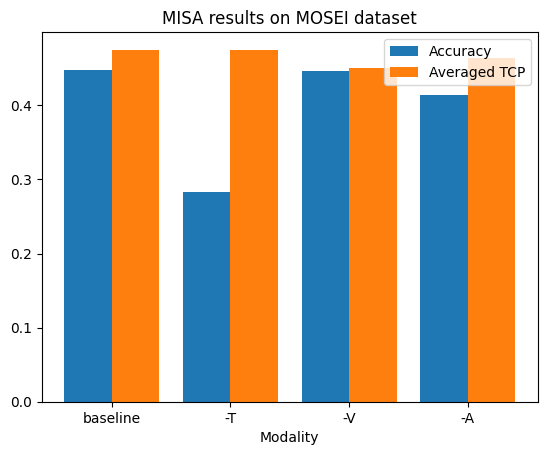

In [89]:
columns = ['baseline','-T', '-V', '-A']
X_axis = np.arange(len(columns))

accuracy = [
    results_dict['accuracy'], results_dict['acc_va'], results_dict['acc_ta'], results_dict['acc_tv']
]

average_tcp = [
    np.mean(results['tcp_TVA']), 
    np.mean(results['tcp_AV']), 
    np.mean(results['tcp_TA']), 
    np.mean(results['tcp_TV']), 
]

# histogram of the data
plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, average_tcp, 0.4, label = 'Averaged TCP')

plt.xticks(X_axis, columns)
plt.xlabel("Modality")
plt.title("MISA results on MOSEI dataset")
plt.legend()
plt.show()

In [90]:
plt.close()

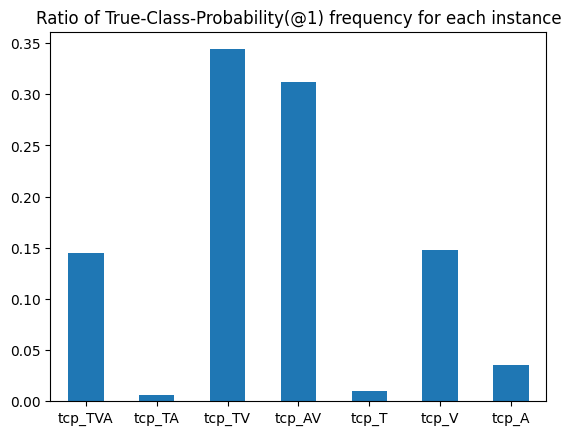

In [106]:
columns = ['tcp_TVA', 'tcp_TA', 'tcp_TV', 'tcp_AV', 'tcp_T', 'tcp_V', 'tcp_A']
results['top_1_column'] = results[['tcp_TVA','tcp_TV','tcp_TA', 'tcp_AV', 'tcp_T', 'tcp_V', 'tcp_A']].idxmax(axis=1)
df = results['top_1_column'].value_counts(sort=False)
df = df / df.sum()
for col in columns:
    if col not in df.index:
        df[col] = 0
df.loc[columns].plot.bar(rot=0, x=columns, title="Ratio of True-Class-Probability(@1) frequency for each instance")
plt.show()

In [92]:
plt.close()

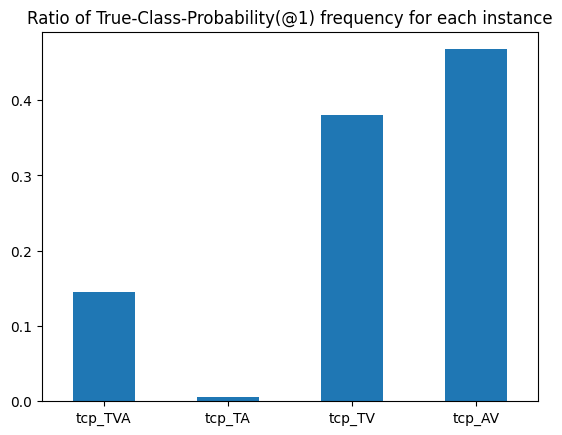

In [107]:
columns = ['tcp_TVA', 'tcp_TA', 'tcp_TV', 'tcp_AV']
results['top_1_column'] = results[['tcp_TVA','tcp_TV','tcp_TA', 'tcp_AV']].idxmax(axis=1)
df = results['top_1_column'].value_counts(sort=False)
df = df / df.sum()
for col in columns:
    if col not in df.index:
        df[col] = 0
df.loc[columns].plot.bar(rot=0, x=columns, title="Ratio of True-Class-Probability(@1) frequency for each instance")
plt.show()

In [94]:
plt.close()